In [128]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import *
import pandas as pd

### Reading the data

In [131]:
data = pd.read_csv("205.rlrdata.txt", sep = ";", header = None, names = ["Date", "MSL","Nmissing_days","Flag"])

print(data)

           Date   MSL  Nmissing_days  Flag
0     1916.0417  6897              0     0
1     1916.1250  6833              0     0
2     1916.2083  6806              0     0
3     1916.2917  6879              0     0
4     1916.3750  6979              0     0
...         ...   ...            ...   ...
1196  2015.7083  6978              0     0
1197  2015.7917  7065              0     0
1198  2015.8750  7288             15     0
1199  2015.9583  7082              0     0
1200  2016.0417  7014              0     0

[1201 rows x 4 columns]


### Removing months which has flags, missing days and no data

In [132]:
data = data[data.Flag == 0] # remove data where there is value for flags

data = data[data.MSL >= 0] # removing data where there is no mean sea level data

data = data[data.Nmissing_days == 0] # removing data which has missing observations in a month

data = data.reset_index(drop=True) # to reset the index after removing all the unneccessary data

print(data)

          Date   MSL  Nmissing_days  Flag
0    1916.0417  6897              0     0
1    1916.1250  6833              0     0
2    1916.2083  6806              0     0
3    1916.2917  6879              0     0
4    1916.3750  6979              0     0
..         ...   ...            ...   ...
586  2015.6250  6986              0     0
587  2015.7083  6978              0     0
588  2015.7917  7065              0     0
589  2015.9583  7082              0     0
590  2016.0417  7014              0     0

[591 rows x 4 columns]


### Decimal year to month and year convert

In [133]:
def year_month(decimal_year): # function for converting decimal years to year and month
    
    curr_month = []
    first_month = 1/(12*2) # first month in decimal value
    curr_year = []
    for i in decimal_year:
        month1 = i - int(i) # separating out only the month of that particular year
        month1 = month1/(first_month*2) # finding which month  
        curr_month.append(int(month1)+1) # 1 is added as the first month value is from 0
        curr_year.append(int(i)) # year
    return curr_year, curr_month

curr_year,curr_month = year_month(data.Date) # year and corresponding month

df1 = pd.DataFrame({"Year" : curr_year, "Month": curr_month}) 

data = pd.concat([data,df1],axis = 1) # adding the year and the month to the dataset

print(data)

          Date   MSL  Nmissing_days  Flag  Year  Month
0    1916.0417  6897              0     0  1916      1
1    1916.1250  6833              0     0  1916      2
2    1916.2083  6806              0     0  1916      3
3    1916.2917  6879              0     0  1916      4
4    1916.3750  6979              0     0  1916      5
..         ...   ...            ...   ...   ...    ...
586  2015.6250  6986              0     0  2015      8
587  2015.7083  6978              0     0  2015      9
588  2015.7917  7065              0     0  2015     10
589  2015.9583  7082              0     0  2015     12
590  2016.0417  7014              0     0  2016      1

[591 rows x 6 columns]


### 2. The values are given with respect to a Revised Local Reference (RLR). A benchmark diagram is given for each station, which you can use to calculate the RLR-referenced tide-gauge values.

In [134]:
def from_RLR(data_year, data_req, val_added,from_data,to_data): # add a value for only certain year to get the MSL from RLR
    MSL_from_RLR = []
    year1 = list(range(from_data, to_data+1)) # the range of years whose data needs to be changed
    for i in range(len(data_year)):
        if int(data_year[i]) in year1: 
            MSL_from_RLR.append(data_req[i] + val_added)
        else:
            MSL_from_RLR.append(data_req[i])
    return MSL_from_RLR

data1 = from_RLR(data.Year, data.MSL, 6.254*10**3, 1916,1920) # add 6254mm for year from 1916 to 1920 
data1 = from_RLR(data.Year, data1, 6.360*10**3, 1952,int(data.Date.iloc[-1])) # add 6360 for year from 1952 to end of the available data

df2 = pd.DataFrame({"MSL_from_RLR" : data1}) # joining the MSL from RLR to the dataset
data = pd.concat([data,df2],axis = 1)

print(data)

          Date   MSL  Nmissing_days  Flag  Year  Month  MSL_from_RLR
0    1916.0417  6897              0     0  1916      1       13151.0
1    1916.1250  6833              0     0  1916      2       13087.0
2    1916.2083  6806              0     0  1916      3       13060.0
3    1916.2917  6879              0     0  1916      4       13133.0
4    1916.3750  6979              0     0  1916      5       13233.0
..         ...   ...            ...   ...   ...    ...           ...
586  2015.6250  6986              0     0  2015      8       13346.0
587  2015.7083  6978              0     0  2015      9       13338.0
588  2015.7917  7065              0     0  2015     10       13425.0
589  2015.9583  7082              0     0  2015     12       13442.0
590  2016.0417  7014              0     0  2016      1       13374.0

[591 rows x 7 columns]


### 3. Compute mean sea level from RLR using the whole dataset

In [136]:
def avg_adj_val(ref_year, entire_year, entire_months, data):

    curr_year = (entire_year - ref_year)*12 # year in months
    curr_month = entire_months-1 # the current month of the corresponding year
    n_months = (curr_year + curr_month) +1 # data of entire year in months

    omega1 = 2*np.pi/12 # monthly frequency 
    omega2 = 2*np.pi/6 # semi annual frequency

    func_values = []
    [func_values.append([1, i, np.cos(omega1*i), np.sin(omega1*i), np.cos(omega2*i), np.sin(omega2*i)]) for i in n_months] # design matrix

    N = np.dot(np.array(func_values).T, func_values) # normal matrix
    
    U = np.dot(np.array(func_values).T,data) # right hand vector

    unknown_X = np.dot(np.linalg.inv(N),U) # unknown parameters. out of this, the first one is averaged MSL
    
    V = np.dot(func_values, unknown_X)  - data # residual value
    
    adj = V + data # adjusted value

    return unknown_X[0], adj

MSL_value, adj = avg_adj_val(1935, data.Year, data.Month, data.MSL_from_RLR) # to get the averaged mean sea level value and the adjusted mean sea level value, taking the reference year as 1935. This year is selected sicne it will be average position for the entire dataset

print(f"The mean sea level value for the entire dataset is {MSL_value} mm")

The mean sea level value for the entire dataset is 13271.434676954585 mm


### 4. You will notice that the original dataset has some data gaps. Choose the longest part of the data which has continuous values without any missing values and compute the mean sea level from it.

In [121]:
orig_data = pd.read_csv("205.rlrdata.txt", sep = ";", header = None, names = ["Date", "MSL","Nmissing_days","Flag"])

In [137]:
def find_lar_cont_ind(original_data, removed_data): # find the longest continuous data without gaps
    i = 0
    j = 0
    k = 0
    max_val = 0
    indices = []
    ind = []
    while i <= len(data.Date)-1:
        if original_data.Date[k] == removed_data.Date[i]: # to check the equality of the data in both the dataset
            indices.append(i)
            j+=1
        else:
            if j > max_val:
                max_val = j
                ind = indices
                indices = []
            i-= 1
            j = 0
        i += 1
        k += 1    
    return ind

continuous_data = find_lar_cont_ind(orig_data, data) # the indices of the most continuous dataset

print(f"The index positions of the most continuous dataset is {continuous_data}")

The index positions of the most continuous dataset is [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]


In [138]:
MSL_value_cont, adjus_cont = avg_adj_val(1935, data.Year[continuous_data], data.Month[continuous_data], data.MSL_from_RLR[continuous_data]) # averaged MSL of the most continuous value in the dataset

print(f"The mean sea level value for the entire dataset is {MSL_value_cont} mm")

The mean sea level value for the entire dataset is 13096.344559084888 mm


### 5. Compare results obtained from both methods. Why is there a difference in both results?

In [139]:
diff_MSL = MSL_value - MSL_value_cont # difference between MSL obtained by entire dataset and from most continuous dataset

print(f"{diff_MSL} mm")

'''There may be many reasons for this difference
--> the continuous data is from 1916 to 1920, so obviously as the sea level is kept on rising, the mean value compared with that also will eb different
--> the data with gaps will be less precise, so the global dataset can be less precise compared to most continuous dataset'''

175.09011786969677 mm


'There may be many reasons for this difference\n--> the continuous data is from 1916 to 1920, so obviously as the sea level is kept on rising, the mean value compared with that also will eb different\n--> the data with gaps will be less precise, so the global dataset can be less precise compared to most continuous dataset'

### 6. Find anomaly for both datasets by subtracting mean sea level values for each dataset.

In [140]:
## the following is done again so that the plotting will show the data gaps

import math as mt

new_MSL = []
for i in range(len(orig_data.MSL)):
    if orig_data.Flag[i] == 0 and orig_data.MSL[i] >= 0 and orig_data.Nmissing_days[i] == 0: # change the value in the MSL dataset to none, if these conditions don't satisfy
        new_MSL.append(orig_data.MSL[i])
    else:
        new_MSL.append(None)
        
df3 = pd.DataFrame({"new_MSL" : new_MSL}) # appending the new mean sea level to the original dataset
orig_data = pd.concat([orig_data,df3],axis = 1)

In [141]:
curr_year,curr_month = year_month(orig_data.Date) # decimal year to year and month

df4 = pd.DataFrame({"Year" : curr_year, "Month": curr_month}) # adding the year and month to the dataset

orig_data = pd.concat([orig_data,df4],axis = 1)  

In [142]:
orig_data1 = from_RLR(orig_data.Year, orig_data.new_MSL, 6.254*10**3, 1916,1920) # adding the value to get the MSL from RLR
orig_data1 = from_RLR(orig_data.Year, orig_data1, 6.360*10**3, 1952,int(data.Date.iloc[-1]))

df5 = pd.DataFrame({"MSL_from_RLR" : orig_data1}) # adding the MSL from RLR to the original dataset
orig_data = pd.concat([orig_data,df5],axis = 1)  

In [143]:
month_name = ["jan","feb","mar","apr","may","june","july","aug","sep","oct","nov","dec"] 

# to change the months from numericals to string names
month_name1 = []
for i in range(len(orig_data)):
    month_name1.append(f"{orig_data.Year[i]} {month_name[orig_data.Month[i]-1]}") 

month_name2 = []
for i in continuous_data:
    month_name2.append(f"{orig_data.Year[i]} {month_name[orig_data.Month[i]-1]}")

#### Anomaly for both datasets

In [144]:
anomaly_for_ent = orig_data.MSL_from_RLR - MSL_value # anomaly of the global dataset

anomaly_for_cont = orig_data.MSL_from_RLR[continuous_data] - MSL_value_cont # anomaly of the mosst continuous dataset

In [145]:
month_name = ["jan","feb","mar","apr","may","june","july","aug","sep","oct","nov","dec"]

# month name as strings in the unnecessary data removed dataset

month_name3 = []
for i in range(len(data)):
    month_name3.append(f"{data.Year[i]} {month_name[data.Month[i]-1]}") 

month_name4 = []
for i in continuous_data:
    month_name4.append(f"{data.Year[i]} {month_name[data.Month[i]-1]}")

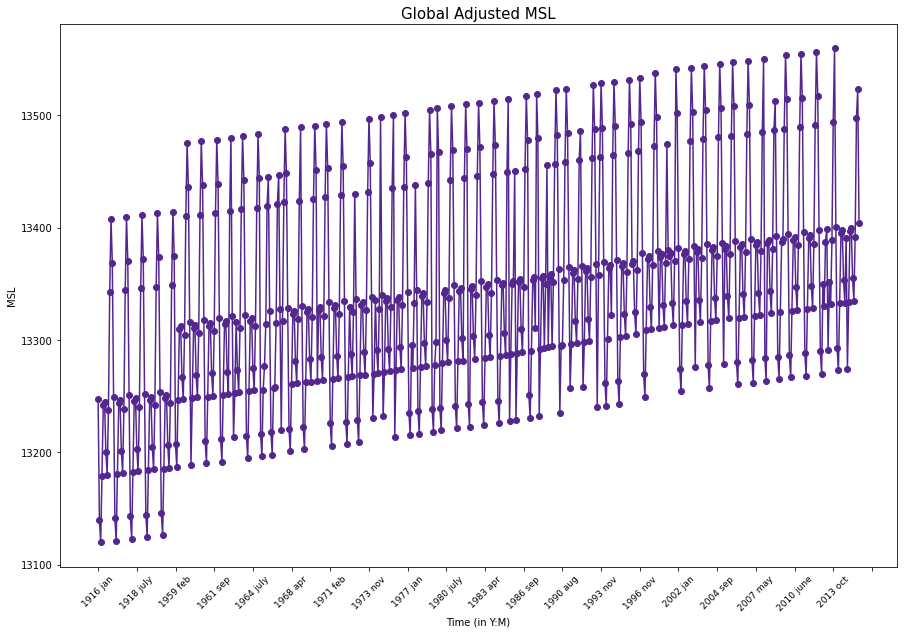

In [146]:
from matplotlib import ticker

fig,ax = plt.subplots(figsize = (15,10))

ax.plot(month_name3,adj, marker = "o", color = "#54278f")
ax.set_title("Global Adjusted MSL", fontsize = 15, pad = 5)
ax.set_xlabel("Time (in Y:M)")
ax.set_ylabel("MSL")
ax.tick_params(axis="x", labelsize=9, rotation = 45) # the tick size is changed to 9
ax.xaxis.set_major_locator(ticker.MaxNLocator(25)) # number of ticks is changed to 25

### 7. Plot time series for anomaly value for both datasets.

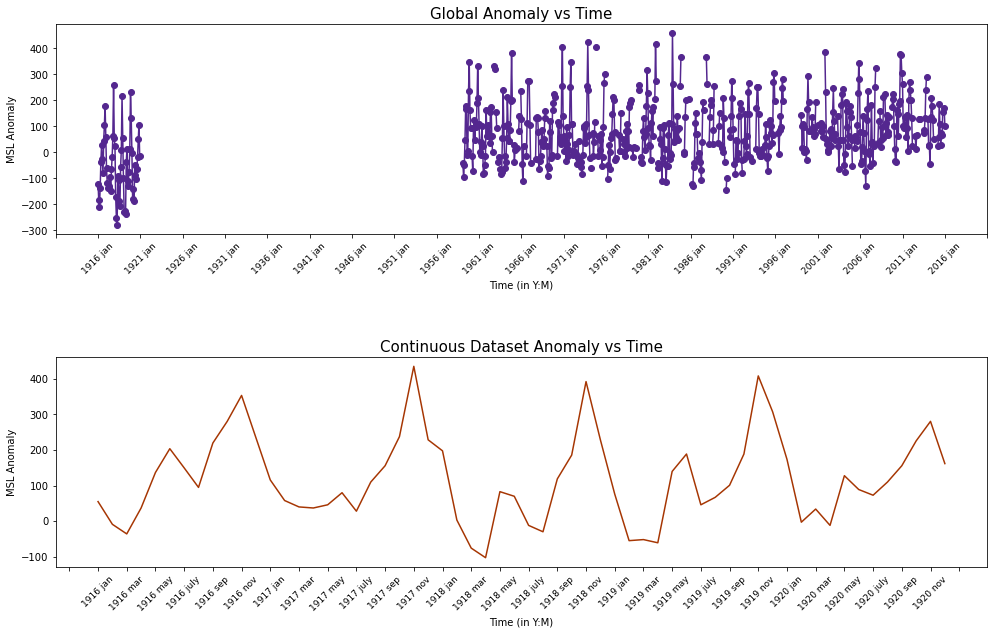

In [147]:
# plotting the anomaly

from matplotlib import ticker

fig,ax = plt.subplots(2,1, figsize = (15,10))

ax[0].plot(month_name1,anomaly_for_ent, marker = "o", color = "#54278f") 
ax[0].set_title("Global Anomaly vs Time", fontsize = 15, pad = 5)
ax[0].set_xlabel("Time (in Y:M)")
ax[0].set_ylabel("MSL Anomaly")
ax[0].tick_params(axis="x", labelsize=9, rotation = 45) # the tick size is changed to 9
ax[0].xaxis.set_major_locator(ticker.MaxNLocator(25)) # number of ticks is changed to 25
ax[1].plot(month_name2,anomaly_for_cont, color = "#a63603")
ax[1].set_title("Continuous Dataset Anomaly vs Time", fontsize = 15, pad = 5)
ax[1].set_xlabel("Time (in Y:M)")
ax[1].set_ylabel("MSL Anomaly")
ax[1].tick_params(axis="x", labelsize=9, rotation = 45) # the tick size is changed to 9
ax[1].xaxis.set_major_locator(ticker.MaxNLocator(40)) # number of ticks is changed to 25
plt.tight_layout(pad = 5)
plt.show()

### 8. Compute mean, median, mode, standard deviation and variance for both datasets.

In [148]:
from statistics import mode, variance, stdev, median

mean_ent = np.mean(data.MSL_from_RLR) # mean value of global dataset

mean_cont = np.mean(data.MSL_from_RLR[continuous_data]) # mean value of continuous dataset

mode1 = mode(data.MSL_from_RLR) # mode of global dataset

mode2 = mode(data.MSL_from_RLR[continuous_data]) # mode value of continuous dataset

variance1 = variance(data.MSL_from_RLR,xbar=mean_ent) # variance value of global dataset # xbar is  the mean of the dataset

variance2 = variance(data.MSL_from_RLR[continuous_data]) # variance of continuous dataset

median1 = median(data.MSL_from_RLR) # # median of global dataset

median2 = median(data.MSL_from_RLR[continuous_data]) # median of continuous dataset

### 9. Apply 3σ test and 6MAD (median absolute deviation) test on the anomaly from seasonal adjusted data and anomaly from continuous data to check for outliers.

In [149]:
# climatology is the mean value of a climate variable computed over a specific period of time

# climate normals is the mean value of a climate variable computed over a period of atleast 30 years

In [150]:
def three_sigma_pos_neg(data): # 3 sigma test

    positive_values = []
    [positive_values.append(i) for i in data if i>=0] # to segreagate the positive values 
    
    negative_values = []
    [negative_values.append(i) for i in data if i<0] # to segregatte the negative values

    up_lim = np.mean(positive_values) + 3*stdev(positive_values) # to find the upper limit values
    low_lim = np.mean(negative_values) - 3*stdev(negative_values) # to find the lower limit values

    out_rem_data = []
    [out_rem_data.append(j) for j in data if j >= low_lim and j <= up_lim] # outlier removed data
    return out_rem_data

In [151]:
def six_MAD(data): # 6 mad test

    median_anomaly = median(data) # median of the data

    MAD = []
    [MAD.append(abs(median_anomaly-i)) for i in data] # to subtract each value with their median and find their absolute value

    low_lim = median_anomaly - median(MAD)*6 # lower limit
    up_lim = median_anomaly + median(MAD)*6 # upper limit

    out_rem_data = []
    [out_rem_data.append(i) for i in data if i >= low_lim and i <= up_lim] # outlier removed data

    return out_rem_data

In [152]:
seasonal_1 = data[data.Month.isin([1, 2, 3, 4, 5, 6])] # semi annual 1 to 6 months

seasonal_2 = data[data['Month'].isin([7,8,9,10,11,12])] # semi annual 7 to 12 months. # two ways to separate the values

seasonal_1_ano = seasonal_1.MSL_from_RLR - np.mean(seasonal_1.MSL_from_RLR) # seasonal anomaly for 1 to 6 months

seasonal_2_ano = seasonal_2.MSL_from_RLR - np.mean(seasonal_2.MSL_from_RLR) # seasonal anomaly for 7 to 12 months

cont_anomaly = data.MSL_from_RLR[continuous_data] - mean_cont # anomaly of continuous data

ent_anomaly = data.MSL_from_RLR - mean_ent # anomaly of global data

three_sigma_season_1 = three_sigma_pos_neg(seasonal_1_ano) # outlier removal using 3 sigma rule

three_sigma_season_2 = three_sigma_pos_neg(seasonal_2_ano)

three_sigma_cont = three_sigma_pos_neg(cont_anomaly)

# outlier removal using 6MAD rule

six_mad_season_1 = six_MAD(seasonal_1_ano)

six_mad_season_2 = six_MAD(seasonal_2_ano)

six_mad_cont =six_MAD(cont_anomaly)

#### 11.  Find trends in the data by fitting a linear line Y = AX + B for all three anomaly datasets.

In [153]:
 def linear_reg(X,Y, P = 1): # to perform linear regression
    
    des_mat = []
    [des_mat.append([i,1]) for i in X] # design matrix

    N = np.dot(np.dot(np.array(des_mat).T, P), des_mat) # normal matrix

    U = np.dot(np.array(des_mat).T,Y) # right hand vector

    unknown_X = np.dot(np.linalg.inv(N),U) # unknown paramters

    V = np.dot(des_mat,unknown_X) - Y # residual matrix

    adj_Y = Y + V # adjusted values

    return adj_Y, unknown_X[0]

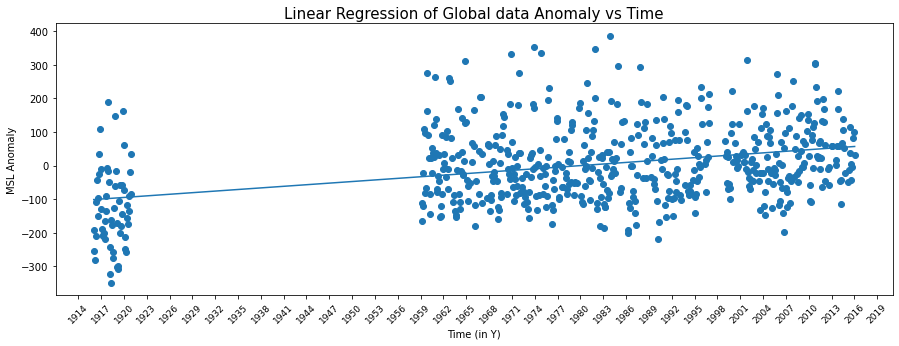

In [154]:
## global anomaly

adj_ano1, trend1 = linear_reg(data.Date, ent_anomaly)

fig,ax = plt.subplots(figsize = (15,5))
ax.plot(data.Date,adj_ano1)
ax.scatter(data.Date, ent_anomaly)
ax.set_title("Linear Regression of Global data Anomaly vs Time", fontsize = 15, pad = 5)
ax.set_xlabel("Time (in Y)")
ax.set_ylabel("MSL Anomaly")
ax.tick_params(axis="x", labelsize=9, rotation = 45) # the tick size is changed to 9
ax.xaxis.set_major_locator(ticker.MaxNLocator(40)) # number of ticks is changed to 25
plt.show()

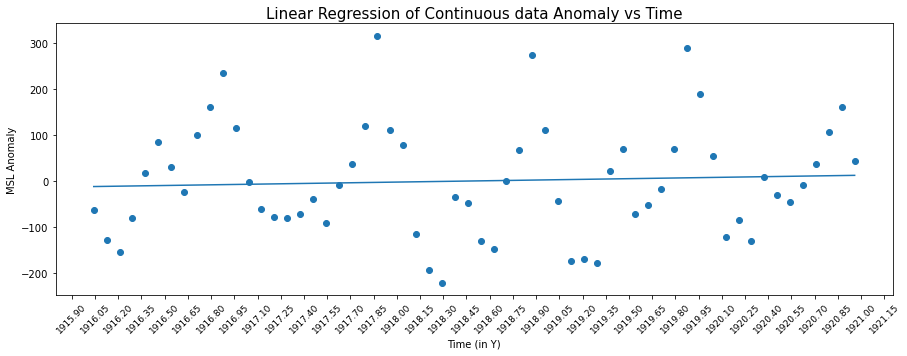

In [155]:
## continuous data anomaly

adj_ano2, trend2 = linear_reg(data.Date[continuous_data], cont_anomaly)

fig,ax = plt.subplots(figsize = (15,5))
ax.plot(data.Date[continuous_data],adj_ano2)
ax.scatter(data.Date[continuous_data], cont_anomaly)
ax.set_title("Linear Regression of Continuous data Anomaly vs Time", fontsize = 15, pad = 5)
ax.set_xlabel("Time (in Y)")
ax.set_ylabel("MSL Anomaly")
ax.tick_params(axis="x", labelsize=9, rotation = 45) # the tick size is changed to 9
ax.xaxis.set_major_locator(ticker.MaxNLocator(40)) # number of ticks is changed to 25
plt.show()

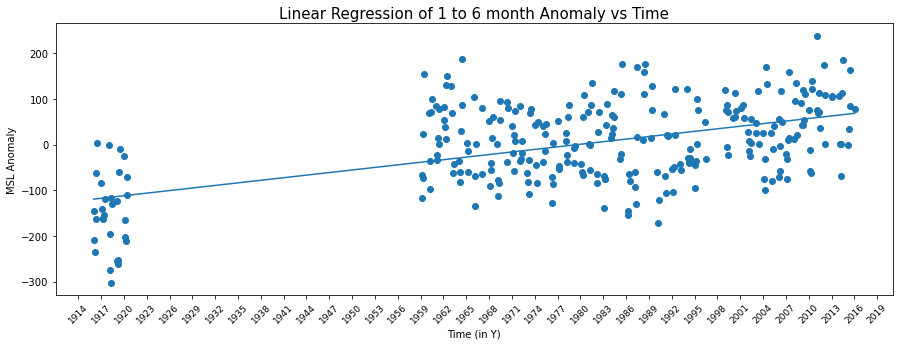

In [156]:
adj_seasonal1, trend3 = linear_reg(seasonal_1.Date, seasonal_1_ano)

fig,ax = plt.subplots(figsize = (15,5))
ax.plot(seasonal_1.Date,adj_seasonal1)
ax.scatter(seasonal_1.Date, seasonal_1_ano)
ax.set_title("Linear Regression of 1 to 6 month Anomaly vs Time", fontsize = 15, pad = 5)
ax.set_xlabel("Time (in Y)")
ax.set_ylabel("MSL Anomaly")
ax.tick_params(axis="x", labelsize=9, rotation = 45) # the tick size is changed to 9
ax.xaxis.set_major_locator(ticker.MaxNLocator(40)) # number of ticks is changed to 25
plt.show()

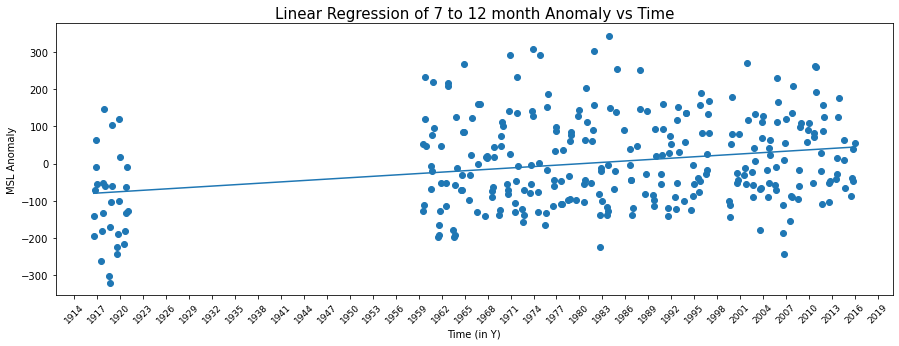

In [157]:
adj_seasonal2, trend4 = linear_reg(seasonal_2.Date, seasonal_2_ano)

fig,ax = plt.subplots(figsize = (15,5))
ax.plot(seasonal_2.Date,adj_seasonal2)
ax.scatter(seasonal_2.Date, seasonal_2_ano)
ax.set_title("Linear Regression of 7 to 12 month Anomaly vs Time", fontsize = 15, pad = 5)
ax.set_xlabel("Time (in Y)")
ax.set_ylabel("MSL Anomaly")
ax.tick_params(axis="x", labelsize=9, rotation = 45) # the tick size is changed to 9
ax.xaxis.set_major_locator(ticker.MaxNLocator(40)) # number of ticks is changed to 25
plt.show()

#### 12. Compute the trend in mean sea level from the anomalies. Compare your result with the global mean sea level trend.

In [158]:
## comparison between global and seasonal

glo_vs_sea1 = trend1 - trend3

print(f"global vs seasonal (1 to 6) trend is {glo_vs_sea1} mm/month")

glo_vs_sea2 = trend1 - trend4

print(f"global vs seasonal (7 to 12) trend is {glo_vs_sea2} mm/month")

## comparison between global and continuous data

glo_vs_cont = trend1 - trend2

print(f"global vs continuus trend is {glo_vs_cont} mm/month")

global vs seasonal (1 to 6) trend is -0.2973428794084527 mm/month
global vs seasonal (7 to 12) trend is 0.33270891019975424 mm/month
global vs continuus trend is -3.384916136232845 mm/month


#### 13. Plot histogram, barplot and violin plot for seasonal adjusted anomaly data and anomaly data computed from continuous data in step 4. Comment on what difference you see after plotting diagrams for both datasets.

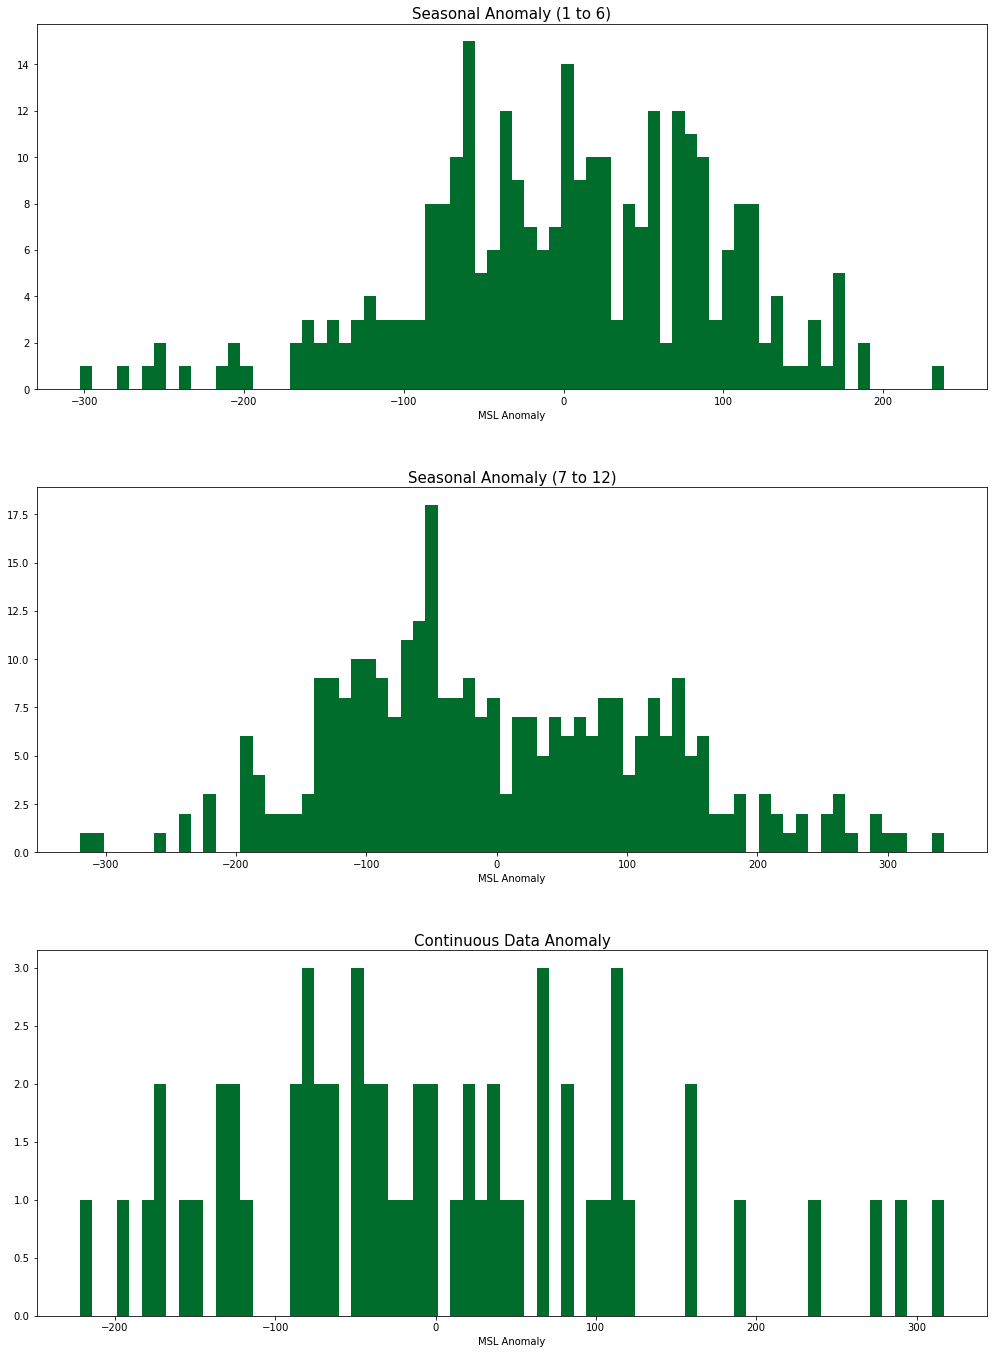

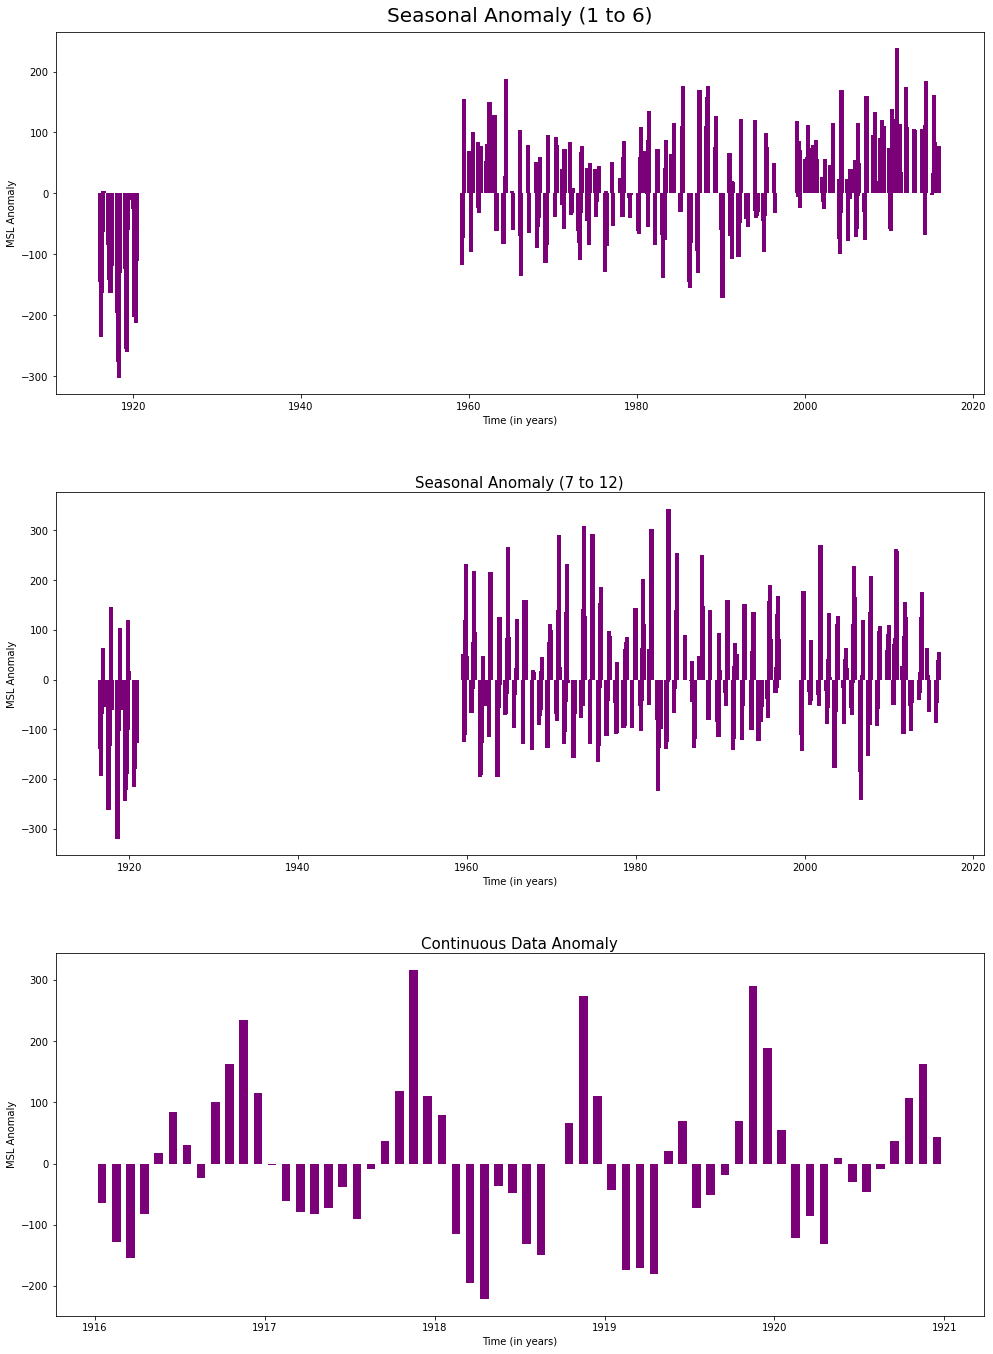

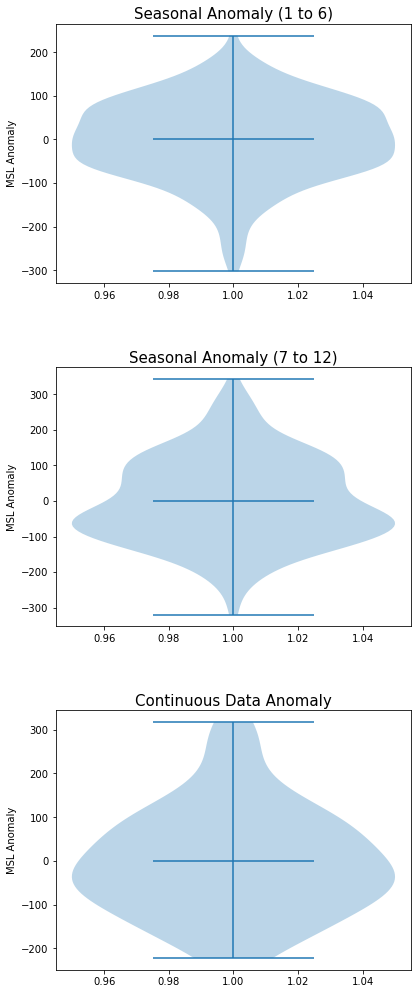

'by seeing the histogram, we can see that seasonal data is accumulated so it is almost same over the period of time\nthe continuous data anomaly is sparse\nthe bar diagram for continuous data shows that the mean sea level variation is almost periodic'

In [160]:
## histogram

fig, ax = plt.subplots(3,1, figsize = (15,20))
ax[0].hist(seasonal_1_ano,bins = 70, histtype = "stepfilled", color = "#006d2c")
ax[0].set_title("Seasonal Anomaly (1 to 6)", fontsize = 15, pad = 5)
ax[0].set_xlabel("MSL Anomaly")

ax[1].hist(seasonal_2_ano,bins = 70, histtype = "stepfilled", color = "#006d2c")
ax[1].set_title("Seasonal Anomaly (7 to 12)", fontsize = 15, pad = 5)
ax[1].set_xlabel("MSL Anomaly")


ax[2].hist(cont_anomaly,bins = 70, histtype = "stepfilled", color = "#006d2c")
ax[2].set_title("Continuous Data Anomaly", fontsize = 15, pad = 5)
ax[2].set_xlabel("MSL Anomaly")
plt.tight_layout(pad = 5)
plt.show()

## barplot

fig, ax = plt.subplots(3,1, figsize = (15,20))
ax[0].bar(seasonal_1.Date, seasonal_1_ano,color = "#7a0177", width = 0.5)
ax[0].set_title("Seasonal Anomaly (1 to 6)", fontsize = 20, pad = 10)
ax[0].set_xlabel("Time (in years)")
ax[0].set_ylabel("MSL Anomaly")

ax[1].bar(seasonal_2.Date, seasonal_2_ano,color = "#7a0177", width = 0.5)
ax[1].set_title("Seasonal Anomaly (7 to 12)", fontsize = 15, pad = 5)
ax[1].set_xlabel("Time (in years)")
ax[1].set_ylabel("MSL Anomaly")

ax[2].bar(data.Date[continuous_data], cont_anomaly, color = "#7a0177", width = 0.05)
ax[2].set_title("Continuous Data Anomaly", fontsize = 15, pad = 5)
ax[2].set_xlabel("Time (in years)")
ax[2].set_ylabel("MSL Anomaly")
plt.tight_layout(pad = 5)
plt.show()

## violin plot

fig, ax = plt.subplots(3,1, figsize = (7,15))
ax[0].violinplot(seasonal_1_ano, vert=True, widths=0.1, showmeans=True, showextrema=True, showmedians=False, quantiles=None, points=100,
bw_method=None)
ax[0].set_title("Seasonal Anomaly (1 to 6)", fontsize = 15, pad = 5)
ax[0].set_ylabel("MSL Anomaly")

ax[1].violinplot(seasonal_2_ano, vert=True, widths=0.1, showmeans=True, showextrema=True, showmedians=False, quantiles=None, points=100,
bw_method=None)
ax[1].set_title("Seasonal Anomaly (7 to 12)", fontsize = 15, pad = 5)
ax[1].set_ylabel("MSL Anomaly")


ax[2].violinplot(cont_anomaly, vert=True, widths=0.1, showmeans=True, showextrema=True, showmedians=False, quantiles=None, points=100,
bw_method=None)
ax[2].set_title("Continuous Data Anomaly", fontsize = 15, pad = 5)
ax[2].set_ylabel("MSL Anomaly")
plt.tight_layout(pad = 5)
plt.show()

'''by seeing the histogram, we can see that seasonal data is accumulated so it is almost same over the period of time
the continuous data anomaly is sparse
the bar diagram for continuous data shows that the mean sea level variation is almost periodic'''

#### 14. Plot these lines on a single plot and see the difference in trend

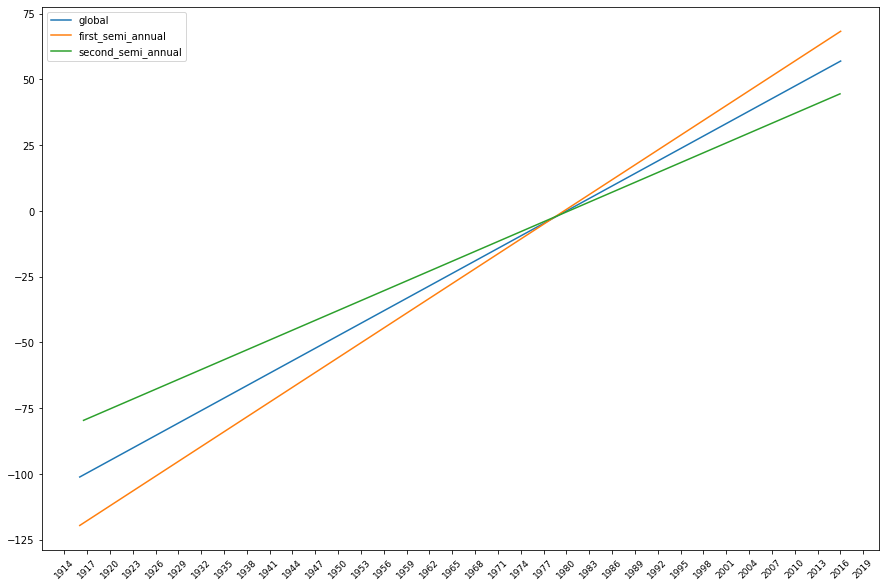

'In the case of Chennai, the sea level tends to rise during the summer months due to an increase in\nthe temperature of the ocean water. When water warms up, it expands, causing the sea level to rise.'

In [163]:
fig,ax = plt.subplots(figsize = (15,10))
ax.plot(data.Date, adj_ano1, label = "global")
ax.plot(seasonal_1.Date,adj_seasonal1, label = "first_semi_annual")
ax.plot(seasonal_2.Date,adj_seasonal2, label = "second_semi_annual")
ax.tick_params(axis="x", labelsize=9, rotation = 45) # the tick size is changed to 9
ax.xaxis.set_major_locator(ticker.MaxNLocator(40)) # number of ticks is changed to 25
plt.legend()
plt.show()
'''In the case of Chennai, the sea level tends to rise during the summer months due to an increase in
the temperature of the ocean water. When water warms up, it expands, causing the sea level to rise.'''

#### 15. Perform 5-year moving average filtering on data and plot it.

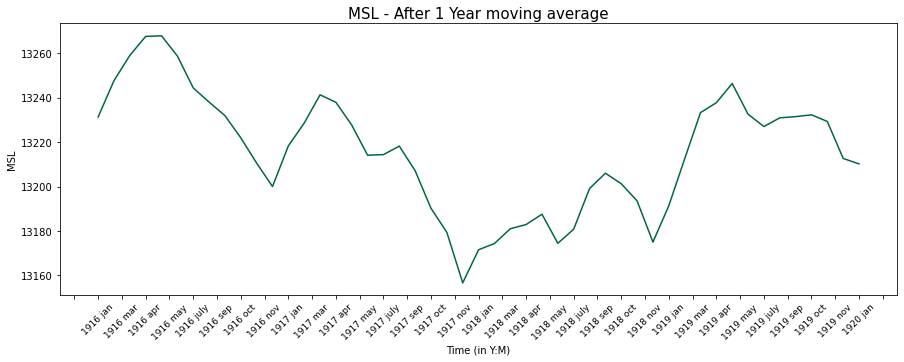

In [164]:
def moving_avg(data, Dates, period): # moving average

    first = 0 # first index
    last = period - 1 # period of moving average required
    conv = []
    req_date = []
    while last != len(data):
        conv.append(np.sum(data[first:last])/(last-first)) # doing convolution to find the moving average
        req_date.append(Dates[first])
        first += 1
        last += 1
    return conv, req_date

# since the data is continuous only for 5 years, so 1 year (12 month) moving average is taken
avg5, req_date = moving_avg(data.MSL_from_RLR[continuous_data],month_name2, 12) 

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(req_date, avg5, color = "#006837")
ax.set_title("MSL - After 1 Year moving average", fontsize = 15, pad = 5)
ax.set_xlabel("Time (in Y:M)")
ax.set_ylabel("MSL")
ax.tick_params(axis="x", labelsize=9, rotation = 45) # the tick size is changed to 9
ax.xaxis.set_major_locator(ticker.MaxNLocator(40)) # number of ticks is changed to 25
plt.show()

#### 16. Compute the Lomb-Scargle Periodogram. The lomb-Scargle periodogram is an algorithm for detecting and characterizing periodic signals in unevenly sampled data. You can use scipy library or astropy library to compute the LombScargle Periodogram.

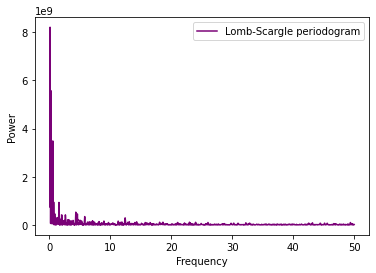

the periodicity is 6.900621118012422 months


In [165]:
import scipy.signal as signal

# Compute the Lomb-Scargle periodogram
freqs = np.linspace(0.1, 50, num=10000) # 50 months divided by 1000 is considered to be the frequecies for which the power is to be found
power = signal.lombscargle(data.Date, data.MSL_from_RLR, freqs) # the power is found
# the frequency corresponding to the highest power is the power of the signal

plt.plot(freqs, power, label='Lomb-Scargle periodogram', color = "#7a0177")
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.legend()
plt.show()

max_val = 0
for index, value in enumerate(power): # to get the position of the maximum power
    if value > max_val:
        max_val = value
        i = index

frequency1 = freqs[i] # frequency of the periodic signal

period = 1/frequency1
print(f"the periodicity is {period} months")

###  infographic for the tide gauge

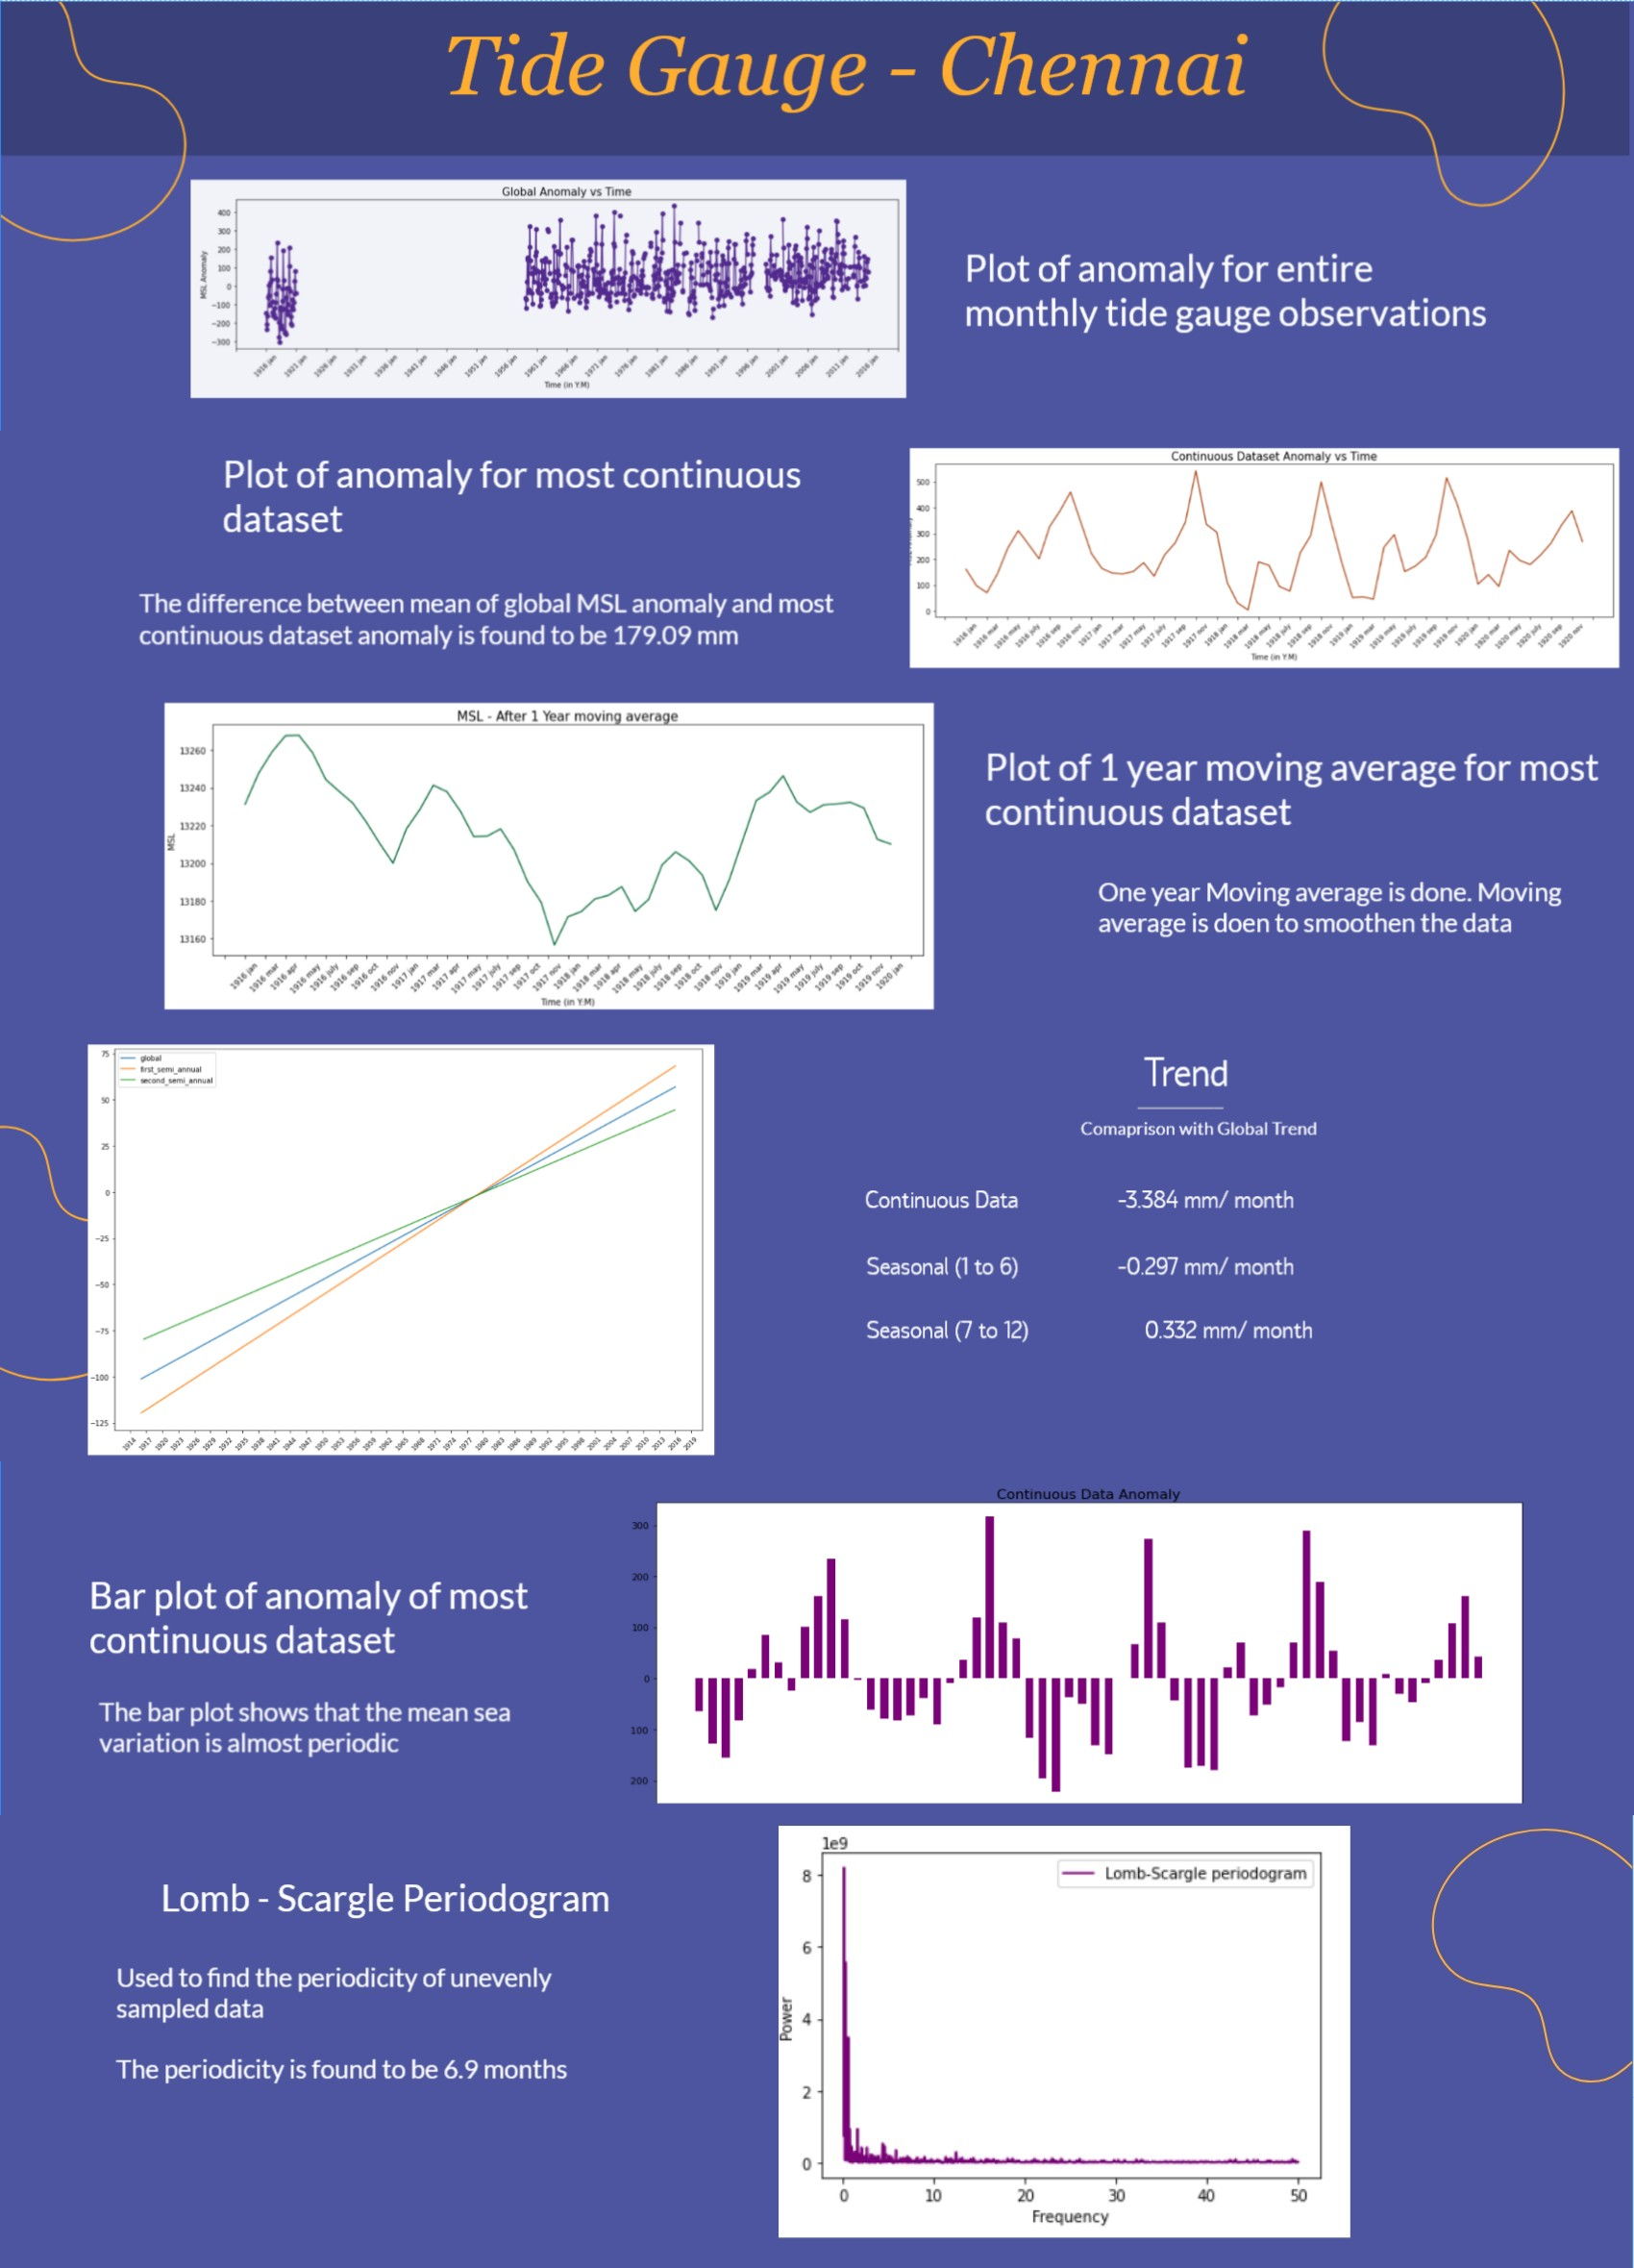